Analyze singles, 6/25/21

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

In [2]:
orig_df = pd.read_csv('../out/features.csv', index_col=0)
print(len(orig_df))

orig_df = orig_df.fillna(0)
orig_df['Name (unique)'] = orig_df.index
orig_df = orig_df.drop_duplicates(subset = 'Name (unique)')

print(len(orig_df))


7416
7416


In [3]:
all_df = pd.read_csv('../out/a_format_data/all_stepcharts.csv', index_col=0)
all_df['Level'] = all_df['METER']

df = orig_df.merge(all_df, on = 'Name (unique)', how = 'left')
print(len(df))

7416


In [4]:
df['Is singles'] = (df['Steptype simple'].str.contains('S'))
singles_df = df[df['Is singles']]

singles_df.shape

(4617, 438)

In [5]:
df = singles_df

### features

In [107]:
for col in df.columns:
    print(col)

Travel (mm) - 50%
Travel (mm) - 80%
Travel (mm) - 99%
Hold - frequency
Hold - 50% nps
Hold - 80% nps
Hold - 99% nps
Hold - max len
Hold - nps of longest
Hold - % 90+ twist
Hold - % diagonal+ twist
Hold taps - frequency
Hold taps - 50% nps
Hold taps - 80% nps
Hold taps - 99% nps
Hold taps - max len
Hold taps - nps of longest
Hold taps - % 90+ twist
Hold taps - % diagonal+ twist
Splits - frequency
Splits - 50% nps
Splits - 80% nps
Splits - 99% nps
Splits - max len
Splits - nps of longest
Splits - % 90+ twist
Splits - % diagonal+ twist
Jump - frequency
Jump - 50% nps
Jump - 80% nps
Jump - 99% nps
Jump - max len
Jump - nps of longest
Jump - % 90+ twist
Jump - % diagonal+ twist
Bracket - frequency
Bracket - 50% nps
Bracket - 80% nps
Bracket - 99% nps
Bracket - max len
Bracket - nps of longest
Bracket - % 90+ twist
Bracket - % diagonal+ twist
Double step - frequency
Double step - 50% nps
Double step - 80% nps
Double step - 99% nps
Double step - max len
Double step - nps of longest
Double ste

In [108]:
stat_cols = [col for col in df.columns if ' - frequency' in col]

for col in stat_cols:
    print(col.replace(' - frequency', ''))

Hold
Hold taps
Splits
Jump
Bracket
Double step
Footswitch
Jack
Bracket footswitch
Hold tap single foot
Hold footslide
Hold footswitch
Staggered hit
Hands
Drill
Run
Hold run
Bracket drill
Irregular rhythm
Bracket jump run
Side3 singles
Mid4 doubles
Mid6 doubles
Run with brackets
Jump run
Stairs, singles
Stairs, doubles
Broken stairs, doubles
Spin
Twist solo diagonal
Twist angle - 90
Twist angle - diagonal
Twist angle - 180


In [26]:
from collections import Counter
Counter(df['Pack'])

Counter({'FIESTA 2': 399,
         'PRO~PRO2': 502,
         'XX': 416,
         'REBIRTH~PREX 3': 295,
         'S.E.~EXTRA': 245,
         'PRIME': 502,
         'NX2': 361,
         'PRIME 2': 383,
         'INFINITY': 168,
         'JUMP': 30,
         'EXCEED~ZERO': 386,
         'FIESTA EX': 242,
         'FIESTA': 231,
         'NX ABSOLUTE': 200,
         '1ST~3RD': 169})

## train model

In [6]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
# model = GradientBoostingRegressor()

nms = list(df['Name (unique)'])
sctypes = []
for typ in ['arcade', 'fullsong', 'shortcut', 'remix']:
    sctype = f'Stepchart - {typ}'
    sctypes.append(sctype)
    df[sctype] = [int(bool(typ in nm)) for nm in nms]

ft_cols = [x for x in orig_df.columns if x != 'Name (unique)'] + sctypes
x = np.array(df[ft_cols])
y = np.array(df['Level'])


# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [94]:
def get_monotonic_constraints(ft_cols):
    cst = []
    no_rel = ['Hold', 'Irregular rhythm', 'Rhythm change', 'Twist angle - none', 'Stepchart']
    for col in ft_cols:
        if any(x in col for x in no_rel):
            cst.append(0)
        else:
            cst.append(1)
    return cst

all_pos = [1]*x.shape[-1]

In [95]:
model = HistGradientBoostingRegressor(monotonic_cst = get_monotonic_constraints(ft_cols))

In [96]:
# Train on entire dataset

model.fit(x, y)
print(model.score(x, y))

pred_level = model.predict(x)
resid = pred_level - y

df['Predicted level'] = pred_level
df['Residual'] = resid

0.9884350271276285


### eval model stats

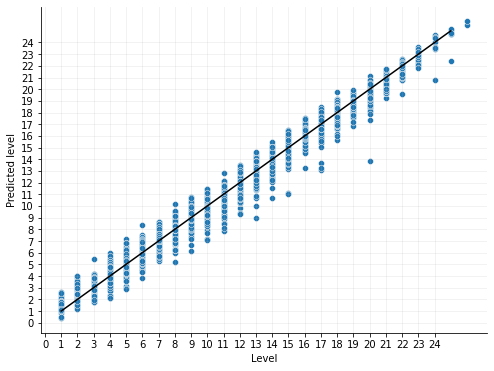

In [97]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
#

sns.scatterplot(
    x = 'Level',
    y = 'Predicted level',
    data = df,
)
sns.despine()
plt.grid(alpha=0.2, markevery=1)

plt.xticks(np.arange(0, 25, 1));
plt.yticks(np.arange(0, 25, 1));

plt.plot([1, 25], [1, 25], '-', color='black')

0.47455057396577865

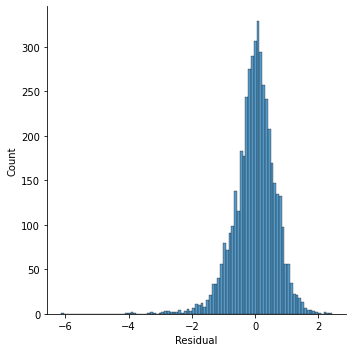

In [98]:
sns.displot(df['Residual'])

sum(df['Residual'] < 0) / len(df)

### rescale model predictions by level


In [123]:
freq_within_1_lower = 0.50
freq_within_1_upper = 0.75
lower_level = 10
upper_level = 16

# freq_within_1 = 0.5

def find_min_scale(data, level):
    data = np.array(data)
    centered_data = data - np.median(data)
    
    frac_in = lambda data: sum(bool(d>-0.5 and d<0.5) for d in data) / len(data)
    
    if level >= upper_level:
        freq_threshold = freq_within_1_upper
    elif level <= lower_level:
        freq_threshold = freq_within_1_lower
    else:
        fq_range = (freq_within_1_upper - freq_within_1_lower)
        rat = (level - lower_level) / (upper_level - lower_level)
        freq_threshold = freq_within_1_lower + fq_range * rat

    scale = 1
    scaled_data = centered_data * scale
    while frac_in(scaled_data) < freq_threshold:
#         print(scale, frac_in(scaled_data))
        scale -= 0.05
        scaled_data = centered_data * scale
    
    scaled_data += level
    print(scale)
    return list(scaled_data)

new_df = pd.DataFrame()
for level in set(df['Level']):
    dfs = df[df['Level'] == level]
    dfs['Predicted level rescaled'] = find_min_scale(list(dfs['Predicted level']), level)
        
    new_df = new_df.append(dfs)
    
new_df['Residual rescaled'] = new_df['Predicted level rescaled'] - new_df['Level']

1
1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1
1
1
1
1
1
1
1
0.8499999999999999
0.8999999999999999
0.7499999999999998
0.8499999999999999
0.7999999999999998
0.8499999999999999
0.8499999999999999
0.7499999999999998
0.8999999999999999
0.7999999999999998
0.7999999999999998
1
1
0.7499999999999998
1
1


###  eval trained model

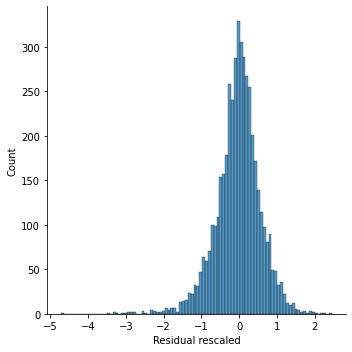

In [127]:
sns.displot(new_df['Residual rescaled'])

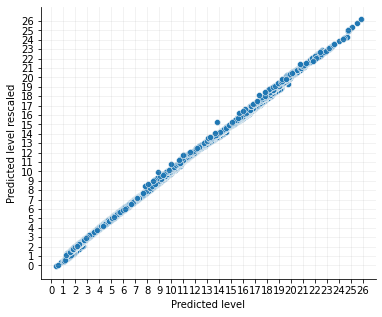

In [128]:
fig, ax = plt.subplots(figsize = (6, 5))
sns.scatterplot(
    x = 'Predicted level',
    y = 'Predicted level rescaled',
    data = new_df,
    ax = ax,
)
plt.grid(alpha=0.2, markevery=1)
plt.xticks(np.arange(0, 27, 1));
plt.yticks(np.arange(0, 27, 1));
sns.despine()

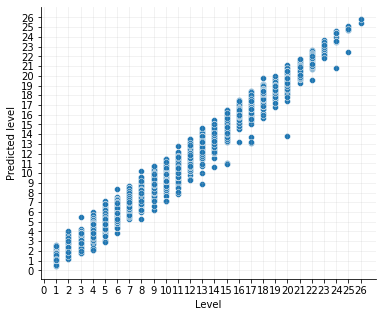

In [129]:
fig, ax = plt.subplots(figsize = (6, 5))
sns.scatterplot(
    x = 'Level',
    y = 'Predicted level',
#     y = 'Predicted level rescaled',
    data = new_df,
    ax = ax,
)
plt.grid(alpha=0.2, markevery=1)
plt.xticks(np.arange(0, 27, 1));
plt.yticks(np.arange(0, 27, 1));
sns.despine()

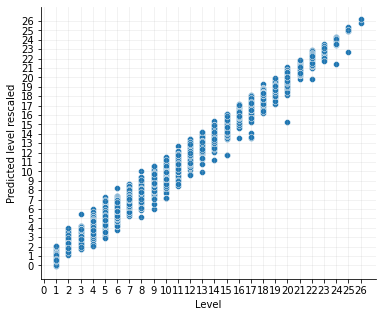

In [130]:
fig, ax = plt.subplots(figsize = (6, 5))
sns.scatterplot(
    x = 'Level',
#     y = 'Predicted level',
    y = 'Predicted level rescaled',
    data = new_df,
    ax = ax,
)
plt.grid(alpha=0.2, markevery=1)
plt.xticks(np.arange(0, 27, 1));
plt.yticks(np.arange(0, 27, 1));
sns.despine()

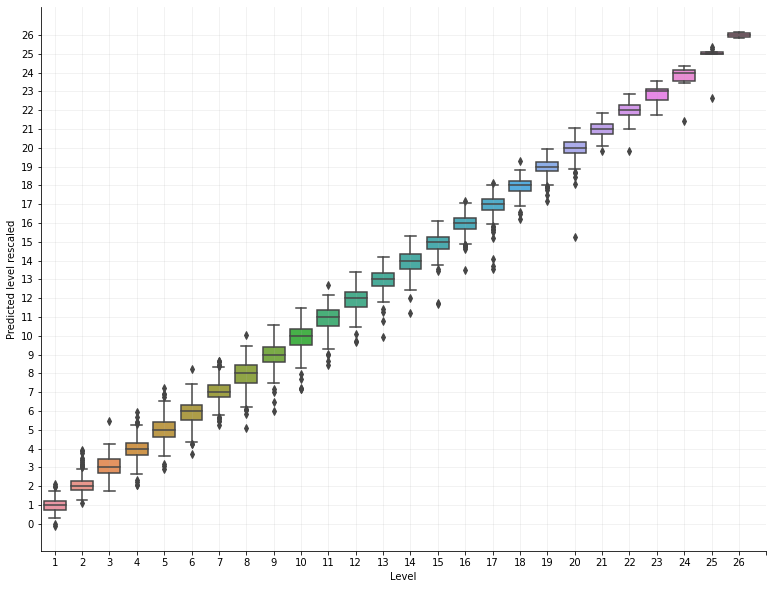

In [132]:
fig, ax = plt.subplots(figsize = (13, 10))
sns.boxplot(
    x = 'Level',
#     y = 'Predicted level',
    y = 'Predicted level rescaled',
    data = new_df,
    ax = ax,
)
plt.grid(alpha=0.2, markevery=1)
plt.xticks(np.arange(0, 27, 1));
plt.yticks(np.arange(0, 27, 1));
sns.despine()

### investigate model predictions

In [124]:
# Most misrated charts

new_df['Residual abs rescaled'] = np.abs(new_df['Residual rescaled'])
subcols = ['Name (unique)', 'Level', 'Predicted level', 'Predicted level rescaled', 'Residual rescaled', 'Residual abs rescaled']
new_df.sort_values(by = 'Residual abs rescaled', ascending=False)[subcols].iloc[:30]

,Name (unique),Level,Predicted level,Predicted level rescaled,Residual rescaled,Residual abs rescaled
4268,Naissance - BanYa S20 arcade,20,13.854032,15.278756,-4.721244,4.721244
3945,LOVE SCENARIO - iKON S17 arcade,17,13.074983,13.561899,-3.438101,3.438101
5810,Pumptris Quattro - YAHPP S17 arcade,17,13.229245,13.693022,-3.306978,3.306978
6125,Fire - 2NE1 S15 arcade,15,10.980592,11.703289,-3.296711,3.296711
583,NoNoNo - Apink SP15 arcade,15,11.067104,11.772499,-3.227501,3.227501
574,Yeo rae a - SID-Sound S13 arcade,13,8.923286,9.956802,-3.043198,3.043198
5250,Take Me Back - KaW S9 arcade v1,9,6.175808,6.028109,-2.971891,2.971891
5723,Uprock - Sam-I-Am S17 arcade,17,13.686820,14.081961,-2.918039,2.918039
5532,Move It Groove It - KaW feat. Sam-I-Am S8 arcade,8,5.234373,5.093400,-2.906600,2.906600
7107,Long Live the Chinese - Wang Lee Hom S10 arcade,10,7.115425,7.148149,-2.851851,2.851851


In [107]:
# Most misrated charts >= 15

new_df['Residual abs rescaled'] = np.abs(new_df['Residual rescaled'])
subcols = ['Name (unique)', 'Level', 'Predicted level', 'Predicted level rescaled', 'Residual rescaled', 'Residual abs rescaled']
new_df[new_df['Level'] >= 15].sort_values(by = 'Residual abs rescaled', ascending=False)[subcols].iloc[:15]

,Name (unique),Level,Predicted level,Predicted level rescaled,Residual rescaled,Residual abs rescaled
4268,Naissance - BanYa S20 arcade,20,13.854032,15.970015,-4.029985,4.029985
3945,LOVE SCENARIO - iKON S17 arcade,17,13.074983,13.628769,-3.371231,3.371231
5810,Pumptris Quattro - YAHPP S17 arcade,17,13.229245,13.759891,-3.240109,3.240109
6125,Fire - 2NE1 S15 arcade,15,10.980592,11.986846,-3.013154,3.013154
583,NoNoNo - Apink SP15 arcade,15,11.067104,12.051731,-2.948269,2.948269
5723,Uprock - Sam-I-Am S17 arcade,17,13.686820,14.148830,-2.851170,2.851170
1910,Rooftop - N.Flying S16 arcade,16,13.225691,13.566385,-2.433615,2.433615
455,VVV - ZiGZaG S25 arcade train,25,22.424513,22.876373,-2.123627,2.123627
3049,Banya-P Classic Mix - Banya S22 remix hidden,22,19.581573,19.991844,-2.008156,2.008156
999,Pine Nut - Doin S24 arcade hidden,24,20.765363,22.189779,-1.810221,1.810221


In [108]:
# Charts pred. harder than their listed level > 16

new_df[new_df['Level'] >= 16].sort_values(by = 'Residual rescaled', ascending=False)[subcols].iloc[:20]

,Name (unique),Level,Predicted level,Predicted level rescaled,Residual rescaled,Residual abs rescaled
291,Hypnosis - BanYa S18 arcade,18,19.758283,19.257386,1.257386,1.257386
6690,Extravaganza - BanYa S16 arcade,16,17.513095,17.210679,1.210679,1.210679
2705,NARCISISTA POR EXCELENCIA - PXNDX S17 fullsong,17,18.443617,18.192107,1.192107,1.192107
7057,Heart Attack - DJ Counterforce S16 arcade,16,17.407191,17.120660,1.120660,1.120660
5086,Slam - Novasonic S17 arcade,17,18.341301,18.105139,1.105139,1.105139
622,! - Onyx S17 arcade,17,18.331862,18.097115,1.097115,1.097115
1523,Final Audition EP. 2-X - YAHPP S20 shortcut,20,21.100299,21.042402,1.042402,1.042402
3150,Tream Vook of the war REMIX - BanYa S17 remix ...,17,18.192508,17.978664,0.978664,0.978664
5035,Bar Bar Bar - Crayon Pop S16 fullsong,16,17.235959,16.975113,0.975113,0.975113
1639,Extravaganza - BanYa S17 arcade hidden,17,18.166483,17.956543,0.956543,0.956543


In [109]:
# Charts pred. harder than their listed level

new_df[new_df['Level'] >= 6].sort_values(by = 'Residual rescaled', ascending=False)[subcols].iloc[:20]

,Name (unique),Level,Predicted level,Predicted level rescaled,Residual rescaled,Residual abs rescaled
5593,Extravaganza - BanYa S6 arcade hidden,6,8.336404,8.287115,2.287115,2.287115
5430,Fire - 2NE1 S8 arcade,8,10.172823,10.090867,2.090867,2.090867
541,Lexy & 1Tym Remix - Lexy 1Tym S11 remix,11,12.810224,12.954188,1.954188,1.954188
4718,D Gang - BanYa S9 arcade,9,10.738806,10.659319,1.659319,1.659319
3206,Chimera - YAHPP S7 arcade,7,8.658306,8.629525,1.629525,1.629525
5214,Final Audition Ep. 2-2 - YAHPP S7 arcade,7,8.650963,8.622182,1.622182,1.622182
7376,We Don't Stop - Asoto Union S9 arcade,9,10.697010,10.617523,1.617523,1.617523
1193,Final Audition Ep. 2-1 - YAHPP S7 arcade,7,8.592852,8.564072,1.564072,1.564072
6883,Get Your Groove On - BanYa S10 arcade hidden,10,11.444088,11.549043,1.549043,1.549043
5515,Cannon X.1 - YAHPP S10 arcade,10,11.437053,11.542008,1.542008,1.542008


In [110]:
new_df[new_df['Name (unique)'] == 'U Got 2 Know - MAX S20 arcade'][subcols]

,Name (unique),Level,Predicted level,Predicted level rescaled,Residual rescaled,Residual abs rescaled
4837,U Got 2 Know - MAX S20 arcade,20,18.521908,19.237528,-0.762472,0.762472


In [111]:
new_df.loc[new_df['Name (unique)'] == 'Houkago Stride - Last Note. S6 arcade', subcols]

,Name (unique),Level,Predicted level,Predicted level rescaled,Residual rescaled,Residual abs rescaled
1796,Houkago Stride - Last Note. S6 arcade,6,7.173251,7.123962,1.123962,1.123962


In [112]:
new_df[new_df['Name (unique)'] == 'ESCAPE - D_AAN S21 arcade v1'][subcols]

,Name (unique),Level,Predicted level,Predicted level rescaled,Residual rescaled,Residual abs rescaled
4832,ESCAPE - D_AAN S21 arcade v1,21,21.55403,21.695074,0.695074,0.695074


In [113]:
new_df[new_df['Name (unique)'] == 'Sorceress Elise - YAHPP S21 arcade'][subcols]

,Name (unique),Level,Predicted level,Predicted level rescaled,Residual rescaled,Residual abs rescaled
6635,Sorceress Elise - YAHPP S21 arcade,21,20.123754,20.550853,-0.449147,0.449147


In [114]:
new_df[new_df['Name (unique)'] == 'Yeo rae a - SID-Sound S13 arcade'][subcols]

,Name (unique),Level,Predicted level,Predicted level rescaled,Residual rescaled,Residual abs rescaled
574,Yeo rae a - SID-Sound S13 arcade,13,8.923286,10.216689,-2.783311,2.783311


In [125]:
new_df[new_df['Name (unique)'] == 'Gothique Resonance - P4Koo S20 arcade'][subcols]

,Name (unique),Level,Predicted level,Predicted level rescaled,Residual rescaled,Residual abs rescaled
876,Gothique Resonance - P4Koo S20 arcade,20,20.482485,20.581519,0.581519,0.581519


In [116]:
# Pred. level by labeled level

lvl = 21
display(new_df[new_df['Level'] == lvl].sort_values(by = 'Predicted level', ascending=False)[subcols].iloc[:20])
display(new_df[new_df['Level'] == lvl].sort_values(by = 'Predicted level', ascending=True)[subcols].iloc[:20])

,Name (unique),Level,Predicted level,Predicted level rescaled,Residual rescaled,Residual abs rescaled
2214,Dream To Nightmare - Nightmare S21 arcade v1,21,21.759843,21.859724,0.859724,0.859724
7409,Nyarlathotep - nato S21 arcade,21,21.711633,21.821156,0.821156,0.821156
4832,ESCAPE - D_AAN S21 arcade v1,21,21.554030,21.695074,0.695074,0.695074
3468,Get Up! - BanYa S21 arcade,21,21.474381,21.631354,0.631354,0.631354
1019,Creed - 1st Desire - - TatshMusicCircle S21 ar...,21,21.393929,21.566993,0.566993,0.566993
3853,Cleaner - Doin S21 shortcut,21,21.352222,21.533628,0.533628,0.533628
4096,Infinity - Lunatic Sounds S21 arcade,21,21.348542,21.530683,0.530683,0.530683
1888,Cleaner - Doin S21 arcade,21,21.344525,21.527470,0.527470,0.527470
5898,Adrenaline Blaster - QWertism S21 arcade,21,21.322573,21.509909,0.509909,0.509909
1709,Ignis Fatuus(DM Ashura Mix) - DM Ashura S21 sh...,21,21.301722,21.493227,0.493227,0.493227


,Name (unique),Level,Predicted level,Predicted level rescaled,Residual rescaled,Residual abs rescaled
3211,Loki - Lotze S21 arcade,21,19.233099,19.838330,-1.161670,1.161670
2640,Love Is A Danger Zone (Cranky Mix) - BanYa & C...,21,19.586842,20.121323,-0.878677,0.878677
3825,Stardream (feat. Romelon) - Cashew S21 arcade,21,19.704579,20.215513,-0.784487,0.784487
4669,Star Command - Zircon S21 fullsong,21,19.708984,20.219037,-0.780963,0.780963
2001,msgoon RMX pt.6 - msgoon S21 remix,21,19.744922,20.247788,-0.752212,0.752212
6462,Dream To Nightmare - Nightmare S21 arcade v2,21,19.806007,20.296656,-0.703344,0.703344
7019,WI-EX-DOC-VA - YAHPP S21 remix,21,19.874507,20.351456,-0.648544,0.648544
5185,CARMEN BUS - StaticSphere & FUGU SUISAN S21 ar...,21,19.946115,20.408742,-0.591258,0.591258
3634,What Happened - Throwdown S21 arcade,21,19.951636,20.413159,-0.586841,0.586841
5815,Baroque Virus - FULL SONG - - Zircon S21 fullsong,21,19.972322,20.429708,-0.570292,0.570292
